In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
from notebooks.Utils import plot_results, plot_annotations,plot_rotatedResult



/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# file_path = "./app/assets/picture1.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"
img = Image.open(file_path)

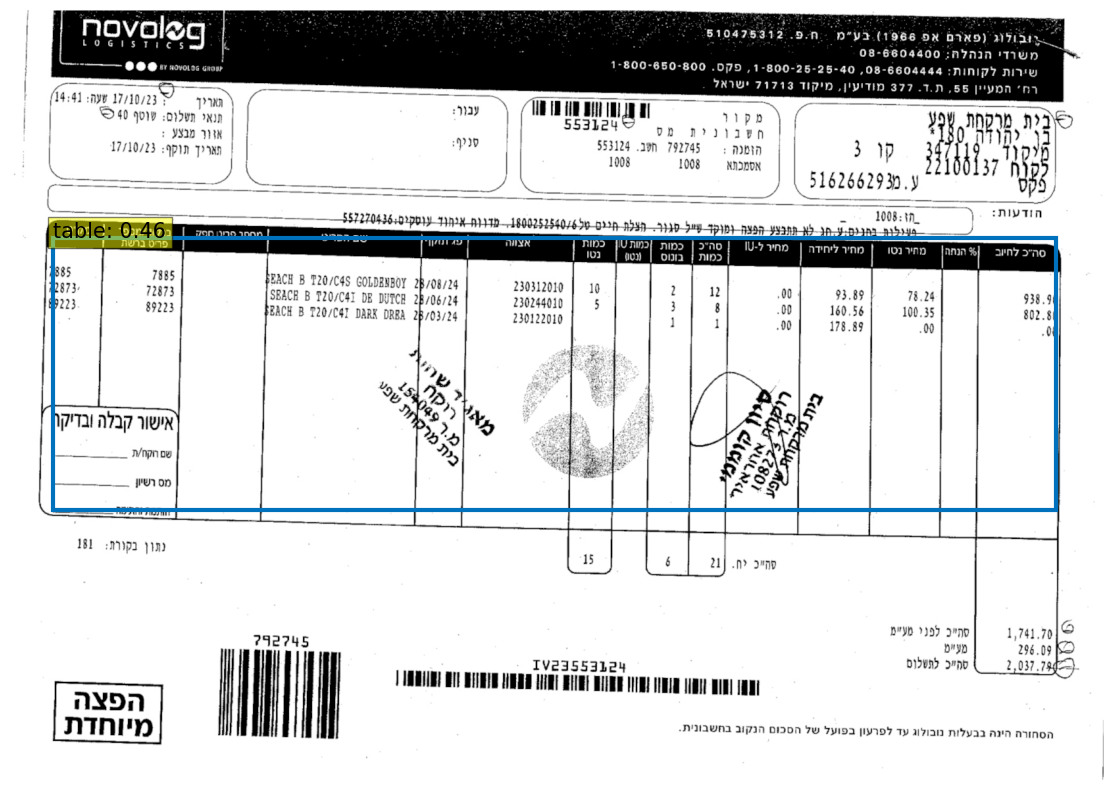

In [4]:
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

checkpoint_load_scucess
shape (1201, 1706, 3)
------ total time: (s): 2.15


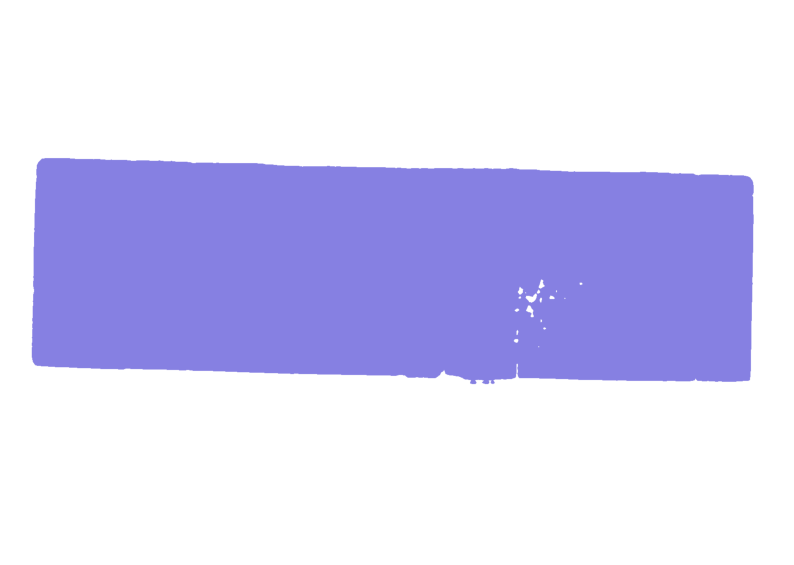

In [5]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)
plot_annotations(sam.image, anns)

In [6]:
w,h = img.size
mask = np.zeros((h,w, 1), np.uint8)
mask.shape

(1201, 1706, 1)

# align table

In [8]:
from tblDetect.AlignTable_Processor import AlignTable_Processor
alignTable_processor = AlignTable_Processor(img, anns[0])

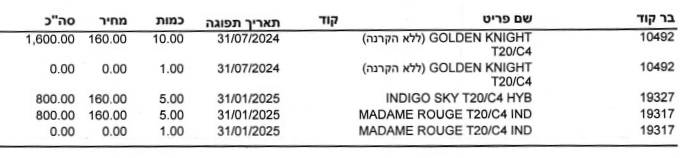

In [9]:
tbl_patch_pil = alignTable_processor.getAlignTable()
tbl_patch_pil


# Table structure recognition

In [10]:
def plot_results_cells(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in tblStructDetect.id2label.values():
      raise ValueError(f"Class should be one of the available classes {tblStructDetect.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=np.random.random(3), linewidth=3))
          plt.axis('off')
          
from tblDetect.TblStructureDetect import TblStructureDetect
tblStructDetect = TblStructureDetect()          

In [11]:
cells = tblStructDetect.detectTableStructure(tbl_patch_pil)

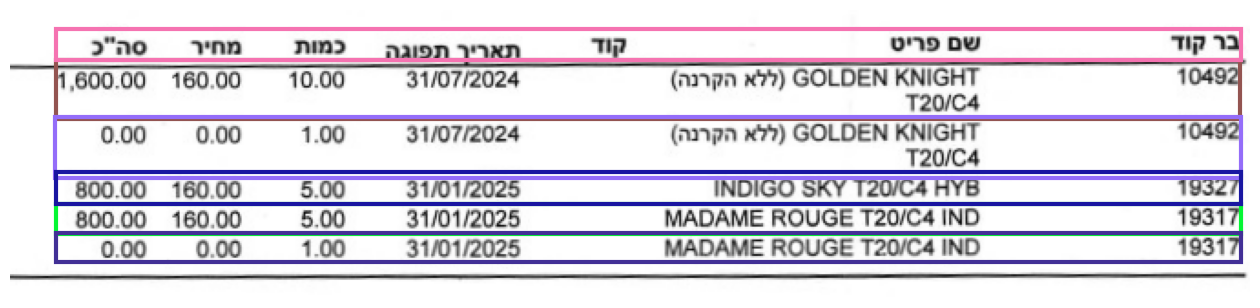

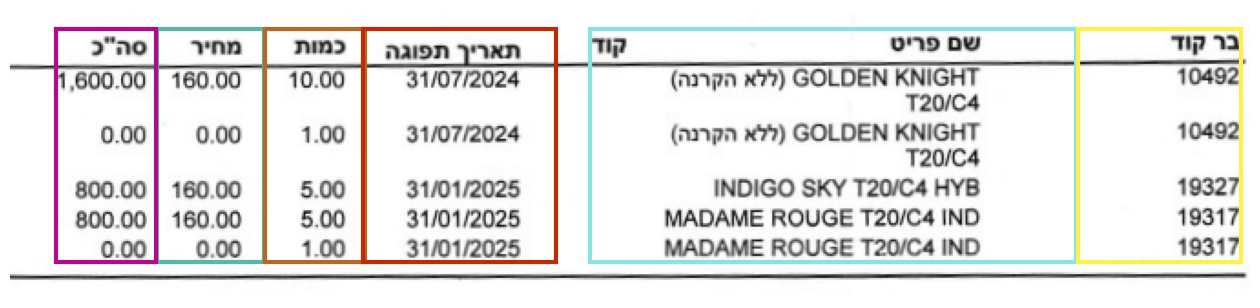

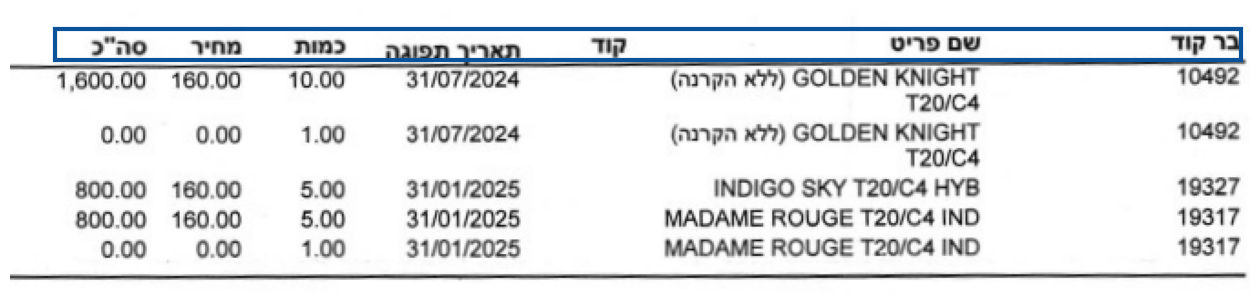

In [12]:
plot_results_cells(tbl_patch_pil,cells, class_to_visualize="table row")
plot_results_cells(tbl_patch_pil, cells, class_to_visualize="table column")
plot_results_cells(tbl_patch_pil,cells, class_to_visualize="table column header")

# Find the inverse rotate

In [14]:
import math

def rotate_point(center, angle, point):
    """
    Calculates the new location of a point after rotation around a center.

    Args:
        center: A tuple (x, y) representing the center of rotation.
        angle: The rotation angle in degrees.
        point: A tuple (x, y) representing the point to be rotated.

    Returns:
        A tuple (x, y) representing the new location of the point.
    """

    # Convert angle to radians
    radians = math.radians(angle)

    # Translate point relative to center
    translated_point = (point[0] - center[0], point[1] - center[1])

    # Apply rotation matrix
    new_x = translated_point[0] * math.cos(radians) - translated_point[1] * math.sin(radians)
    new_y = translated_point[0] * math.sin(radians) + translated_point[1] * math.cos(radians)

    # Translate back to original coordinate system
    rotated_point = (int(new_x + center[0]), int(new_y + center[1]))

    return rotated_point

In [15]:
center,_,angle = alignTable_processor.minAreaRect
center,_,angle

((372.86627197265625, 494.8048095703125),
 (137.38949584960938, 675.6065673828125),
 88.37994384765625)

In [28]:
cell = cells[1]
(x1,y1,x2,y2) = cell["bbox"]
bbox4 = np.array([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
xBias, yBias, _, _ = alignTable_processor.cropBBox
bbox4[:,0] += xBias
bbox4[:,1] += yBias
# bbox4

In [29]:
rotated_bbox = np.array([rotate_point(center,angle-90,pt) for pt in bbox4])

/var/folders/yb/0c4mt25s0cd6btj71b9f7qfc0000gn/T/ipykernel_81215/4112953630.py:6: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv2.circle(tmpImg, np.int0(center), radius=5, color=(0, 0, 255), thickness=-1)


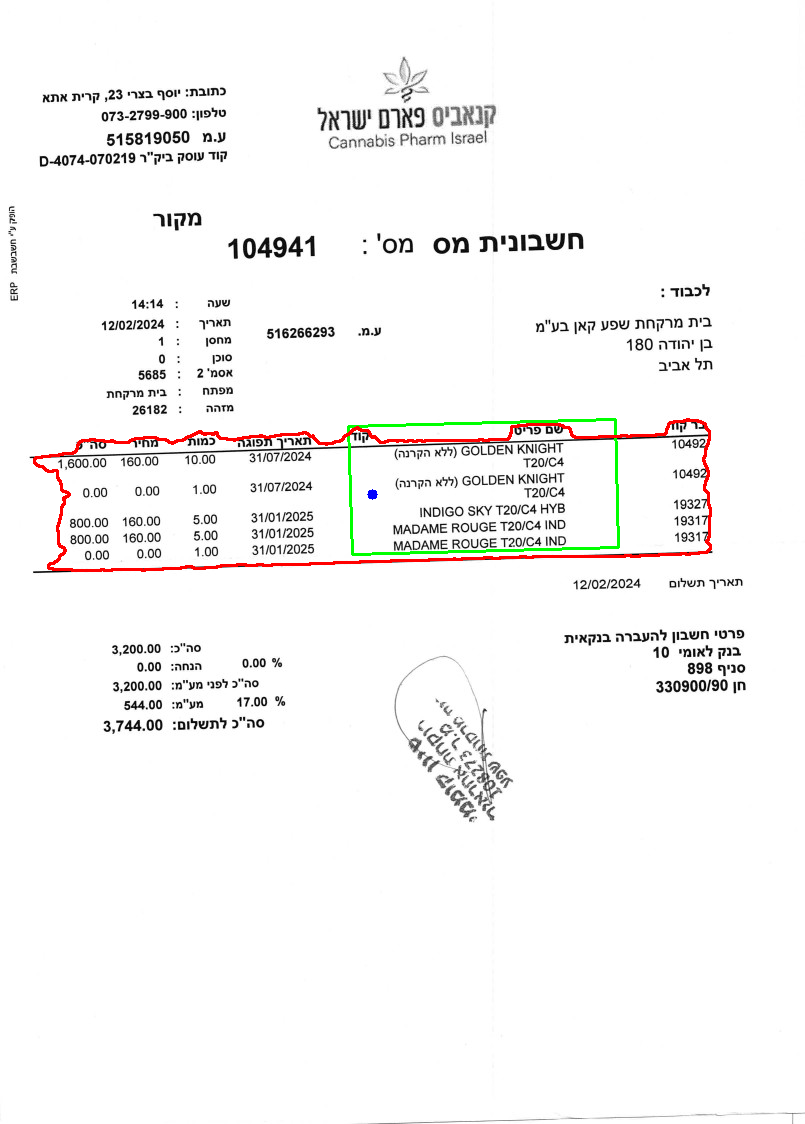

In [30]:
import cv2
tmpImg = np.array(img)
# cv2.drawContours(tmpImg, [np.int0(bbox4)], 0, (0, 255, 0), 2)  # Green bounding box with thickness 2
cv2.drawContours(tmpImg, [rotated_bbox], 0, (0, 255, 0), 2)  # Green bounding box with thickness 2
cv2.drawContours(tmpImg, [alignTable_processor.contour], 0, (255, 0, 0), 2)  # Green bounding box with thickness 2
cv2.circle(tmpImg, np.int0(center), radius=5, color=(0, 0, 255), thickness=-1)
Image.fromarray(tmpImg)